In [ ]:

import os
import torch
import yaml
import cv2
import numpy as np
from pathlib import Path
from IPython.display import display, Image
from basicsr.test import test_pipeline
from basicsr.models import build_model
from basicsr.data import build_dataset, build_dataloader
from tgsr.models.hat_model import HATModel

os.environ['CUDA_VISIBLE_DEVICES'] = "1,2,3"

def read_first_frame(video_path):
    cap = cv2.VideoCapture(video_path)
    success, frame = cap.read()
    cap.release()
    return frame if success else None

def make_image_pair(img1, img2):
    max_height = max(img1.shape[0], img2.shape[0])
    max_width = max(img1.shape[1], img2.shape[1])
    img1 = cv2.resize(img1, (max_width, max_height))
    img2 = cv2.resize(img2, (max_width, max_height))
    separator = np.ones((max_height, 10, 3), dtype=np.uint8) * 255
    img = np.hstack((img1, separator, img2))
    return img


def show_image(image):
    _, encoded_image = cv2.imencode('.png', image)  # 将图像编码为 PNG
    display(Image(data=encoded_image.tobytes()))  # 在 Jupyter 中显示图像


cfg_path = 'options/video.yml'
opt = yaml.full_load(open(cfg_path, encoding='UTF-8'))
print(f'加载配置文件:{cfg_path}')

model = HATModel(opt)
print('测试环境加载完成')

加载配置文件:options/video.yml
测试环境加载完成


In [10]:
video_dir = opt['video_dir']
print(f'待处理视频目录:{video_dir}')
video_files = sorted(list(Path(video_dir).rglob('*.mp4')))
print(f'开始运行，待处理视频数量:{len(video_files)}')

待处理视频目录:input/videos/
开始运行，待处理视频数量:1


正在处理视频(0/1): input/videos/example.mp4


  0%|          | 0/20 [00:00<?, ?it/s]

100%|██████████| 20/20 [00:55<00:00,  2.76s/it]


视频(0/1)处理完成，第一帧修复结果：


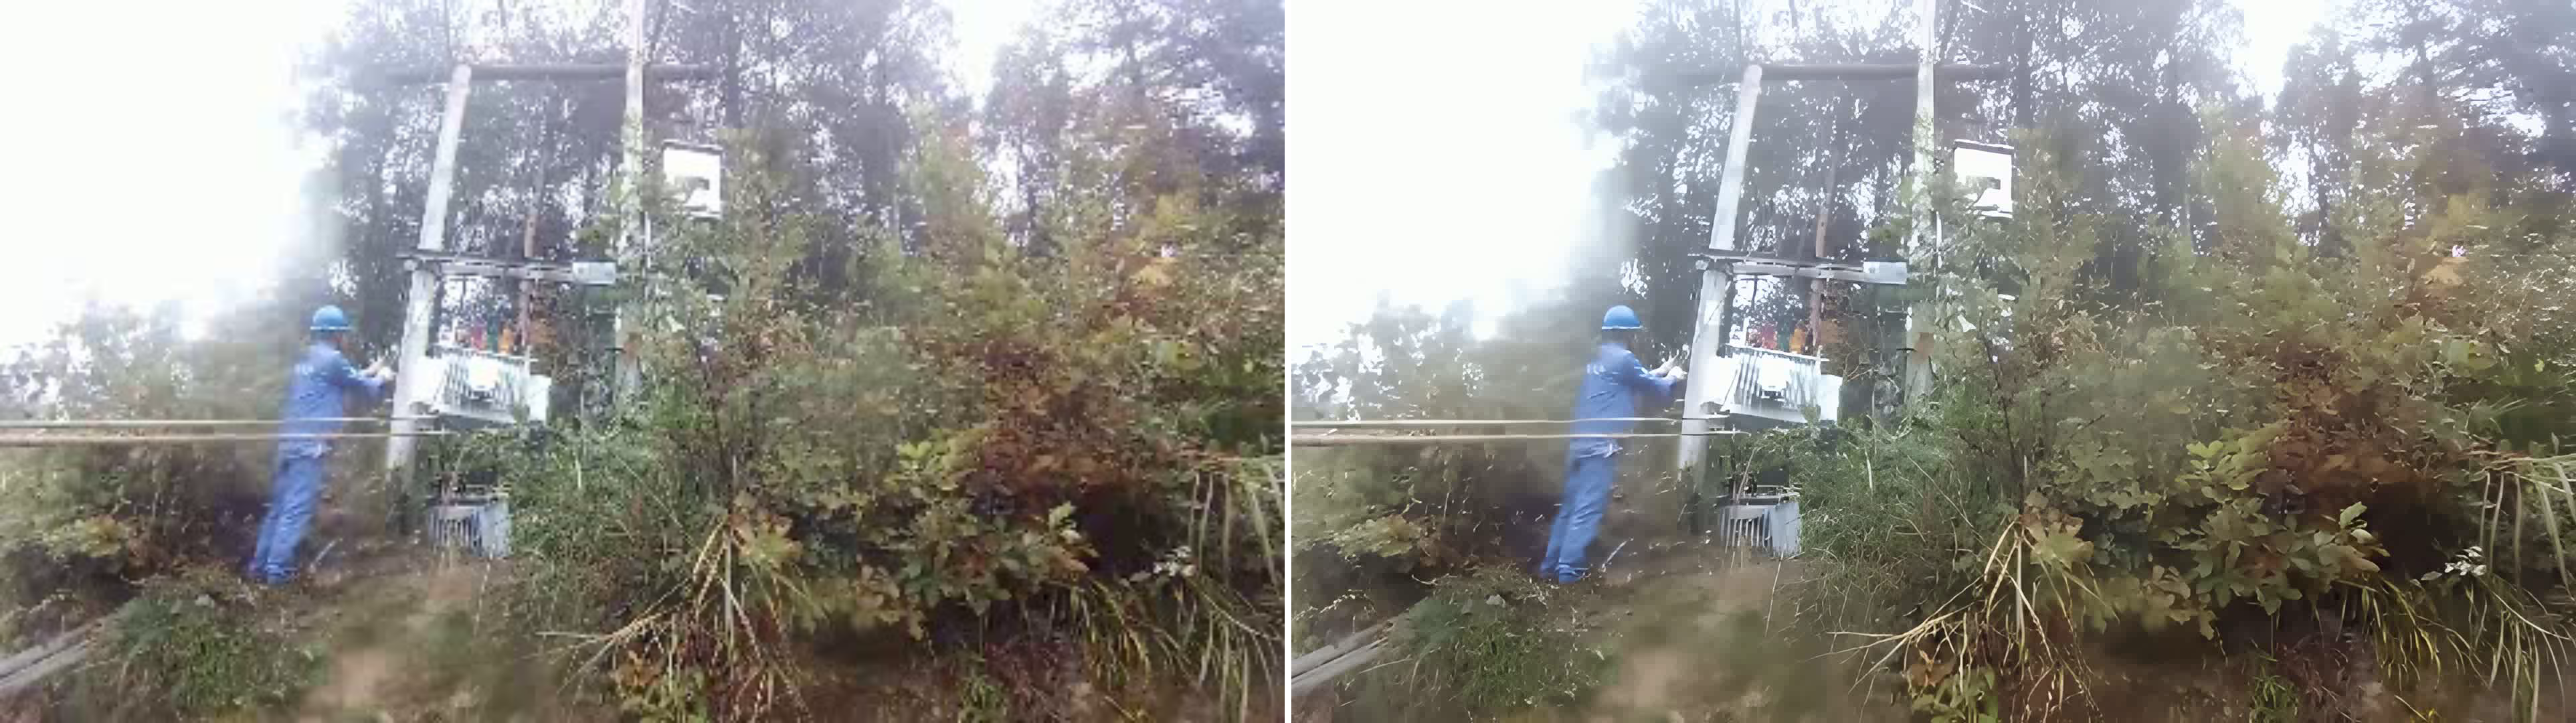

In [11]:
for i, video_path in enumerate(video_files):
    video_path = str(video_path)
    print(f'正在处理视频({i}/{len(video_files)}): {video_path}')
    dataset_opts = {
        'name': f'video{i}',
        'type': 'SingleVideoDataset',
        'phase': 'val',
        'video_path': video_path
    }
    data_set = build_dataset(dataset_opts)
    data_loader = build_dataloader(
        data_set, dataset_opts, 
        num_gpu=opt['num_gpu'], dist=opt['dist'], sampler=None, seed=opt['manual_seed']
    )
    out_path = model.restoration_video(data_loader, opt['output_dir'])
    pre_frame = read_first_frame(video_path)
    post_frame = read_first_frame(out_path)
    img = make_image_pair(pre_frame, post_frame)
    print(f'视频({i}/{len(video_files)})处理完成，第一帧修复结果：')
    show_image(img)